## Anomaly Detection in Particle Physics Using AI at the LHC

*Jordan Pfeifer, Ekin Secilmis, Egor Serebriakov*

### About the Data Used in the Project

We have three "black boxes'' meant to be representative of the actual data from LHC. Each "black box" contains 1M events. The given events might have signals that we consider as anomaly signals. 

Additionally, we have a background sample of 1M events simulated using Pythia8 and Delphes. This data was simulated in order to aid in the anomaly detection from the "black boxes". However, some assumption during the simulation might not exactly reflect the "black boxes" data.

All datasets are stored as pandas DataFrames saved to compressed h5 format. Each event consists of 700 particles (we might have some events with some degree of zero padding) and each particle has three coordinates (pT, eta, phi).

> *Note [0]:* This Python script is written in the way that it can be used for many different types of ML $\texttt{torch}$ models. To change the model, we only need to include a new model class into *preprocess.py* and import it in this notebook.

> *Note [1]:* When we use $\texttt{TensorFlow}$, for some reason Oscar cannot work on GPUs. Therefore, we did preprocessing twice: first using $\texttt{TensorFlow}$ as discussed in the slides/report (located in the *tf_preprocess* directory) and then using $\texttt{torch Dataset}$ and $\texttt{DataLoader}$.

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch import nn
import pandas as pd

In [2]:
# For aesthetics/plotting.
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.style.use("seaborn-v0_8")

In [3]:
# Import the "backend" of the model.
from preprocess import AnomalyDetectionDataset, device_change
from model import AutoencoderAnomalyDetection, TransformerAnomalyDetection
from model import train_loop, test_loop, train_model, evaluate_model

### Getting Data with pytorch

In [4]:
data_dir = '/users/eserebri/data/eserebri/PHYS2550FinalProject/anomaly detection'
train_path = f'{data_dir}/X_train.csv'
test_path = f'{data_dir}/X_test.csv'
valid_path = f'{data_dir}/X_valid.csv'

In [5]:
# Switch to GPU if there is one.
device = device_change()

Using cuda device


In [6]:
# Get train, test and validation datasets.
X_train = AnomalyDetectionDataset(train_path)
X_test = AnomalyDetectionDataset(test_path)
X_valid = AnomalyDetectionDataset(valid_path)

### Model Implementation

In [7]:
# Hyperparameters.
learning_rate = 1e-5
weight_decay = 1e-3 # For l2 regularization.
batch_size = 350
epochs = 50

In [8]:
# torch.utils.DataLoader.
torch.manual_seed(42)
X_train_dataloader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
X_test_dataloader = DataLoader(X_test, batch_size=batch_size, shuffle=True)
X_valid_dataloader = DataLoader(X_valid, batch_size=batch_size, shuffle=True)

In [9]:
# Choose model, loss function, optimizer, and learning rate scheduler.
model = AutoencoderAnomalyDetection().to(device)
print(model)
loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = exp_scheduler(optimizer=optimizer, gamma=0.95) # If we use a scheduled learning rate.

AutoencoderAnomalyDetection(
  (encoder): Sequential(
    (0): Linear(in_features=2100, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=2100, bias=True)
  )
)


### Training Model

Epoch 1
-------------------------------
loss: 2.907181  [  350/680000]
loss: 0.560600  [35350/680000]
loss: 0.423895  [70350/680000]
loss: 0.539023  [105350/680000]
loss: 0.536799  [140350/680000]
loss: 0.509676  [175350/680000]
loss: 2.346544  [210350/680000]
loss: 0.397441  [245350/680000]
loss: 0.604935  [280350/680000]
loss: 0.521666  [315350/680000]
loss: 0.544219  [350350/680000]
loss: 0.440517  [385350/680000]
loss: 0.592842  [420350/680000]
loss: 0.445355  [455350/680000]
loss: 0.517794  [490350/680000]
loss: 0.441994  [525350/680000]
loss: 0.841654  [560350/680000]
loss: 0.499599  [595350/680000]
loss: 0.489909  [630350/680000]
loss: 0.488362  [665350/680000]
Average train loss over the number of batches: 0.770105 

Average test loss over the number of batches: 0.875467 

Done!
Epoch 2
-------------------------------
loss: 0.541553  [  350/680000]
loss: 0.780428  [35350/680000]
loss: 0.573159  [70350/680000]
loss: 0.501581  [105350/680000]
loss: 0.623796  [140350/680000]
loss:

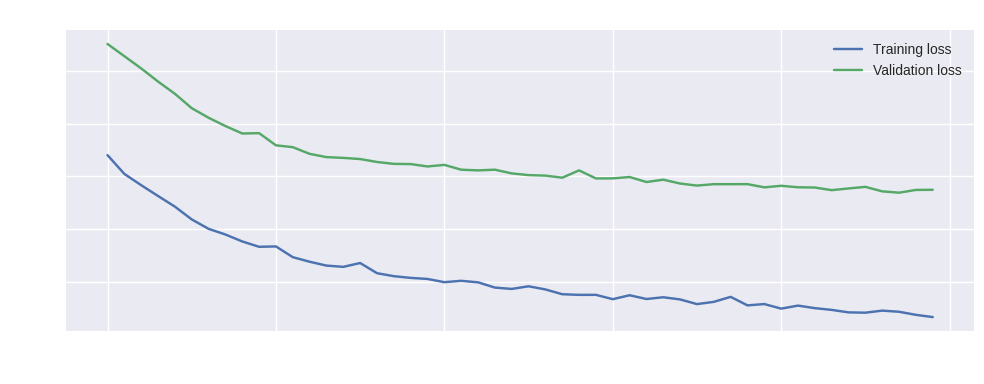

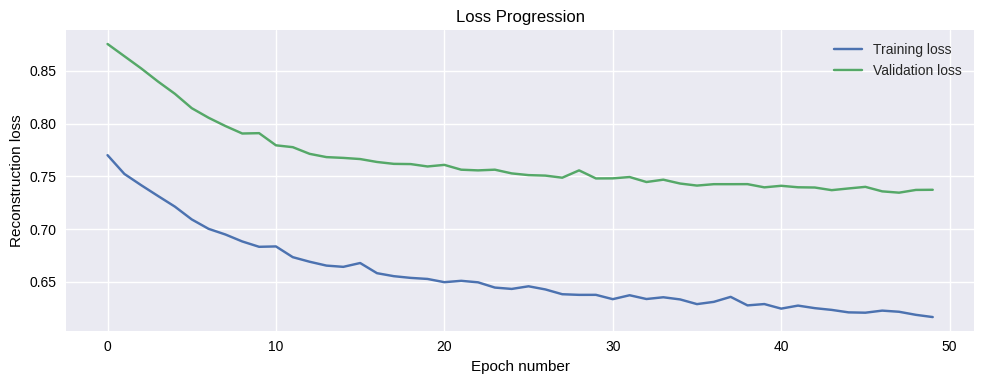

In [10]:
# Train the model on the background data, plot, and save it.
train_loss, valid_loss = train_model(
    X_train_dataloader, 
    X_valid_dataloader, 
    model, 
    loss_func, 
    optimizer, 
    epochs, 
    scheduler=None,
    batch_size=batch_size, 
    graph_path=f'{data_dir}/graphs/testing.png'
)

#### Saving Model Parameters

In [11]:
# Path to save model parameters to use it for the evaluation part.
PATH = f'{data_dir}/model_par/autoencoder_state_dict.pth'
torch.save(model.state_dict(), PATH)

### Making Quick Predictions

> *Note:* this section is discussed in detail in the *evaluation.ipynb* notebook.

In [12]:
# Predictions.
test_loss = evaluate_model(
    X_test_dataloader,
    model,
    loss_func,
    batch_size=batch_size
)

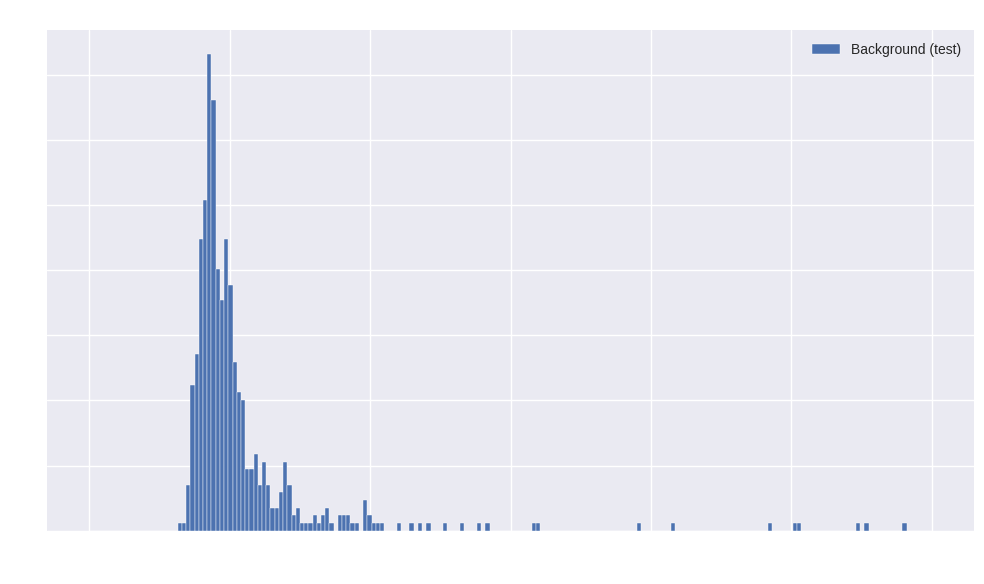

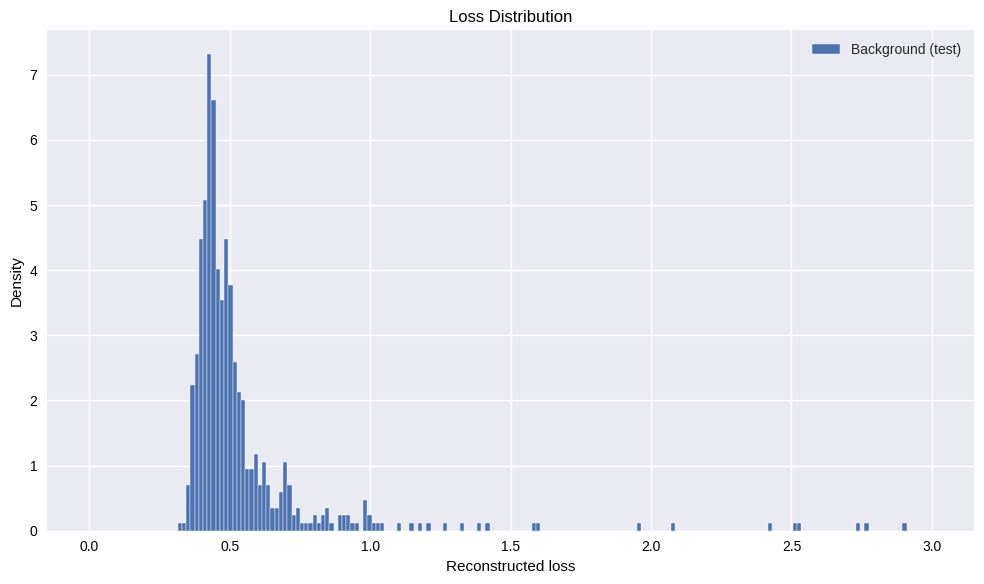

In [13]:
graph_text_face = [('white', 'none'), ('black', 'white')]
for (text_color, face_color) in graph_text_face:
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=face_color)
    plt.hist(test_loss, bins=200, range=(0,3), label='Background (test)', density=True)
    ax.set_title("Loss Distribution", color=text_color)
    ax.set_xlabel("Reconstructed loss", color=text_color)
    ax.set_ylabel("Density", color=text_color)
    ax.legend(facecolor=face_color)
    ax.tick_params(axis='both', colors=text_color)
    plt.tight_layout()
    # plt.savefig(f'{data_dir}/graphs/background_loss_density_{face_color}.png', dpi=600, bbox_inches='tight')
plt.show()

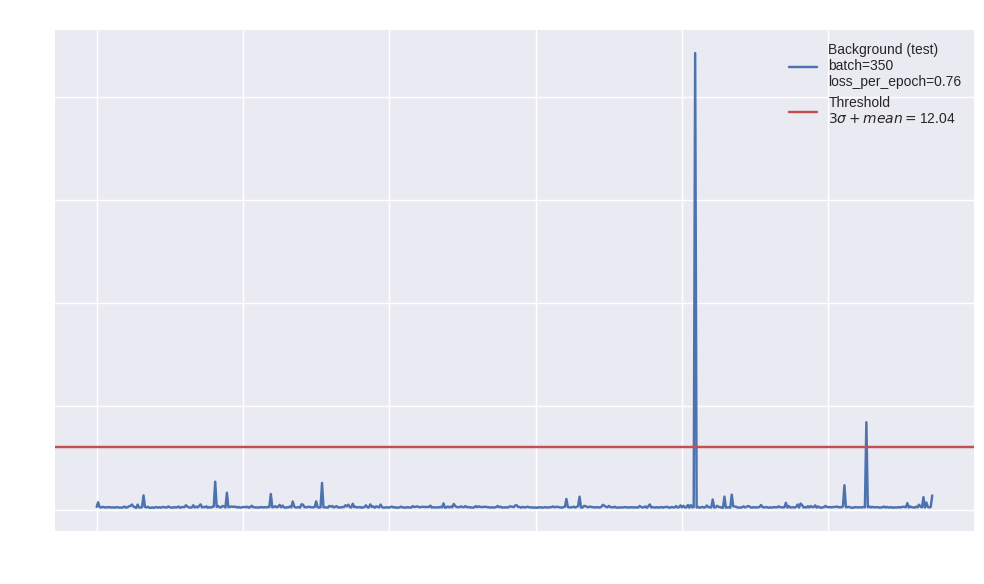

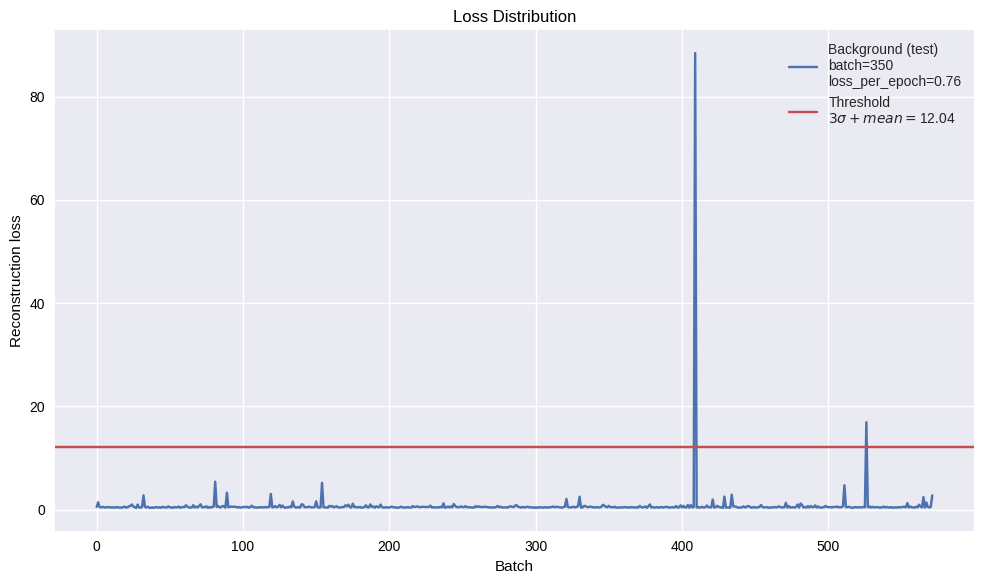

In [14]:
threshold = 3 * test_loss.std() + test_loss.mean()
graph_text_face = [('white', 'none'), ('black', 'white')]
for (text_color, face_color) in graph_text_face:
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=face_color)
    plt.plot(test_loss, label=f'Background (test)\nbatch={batch_size}\nloss_per_epoch={test_loss.mean():.2f}')
    plt.axhline(threshold, color=sns.color_palette()[2], label=f'Threshold\n$3\sigma+mean=${threshold:.2f}')
    ax.set_title("Loss Distribution", color=text_color)
    plt.legend('best')
    ax.set_xlabel("Batch", color=text_color)
    ax.set_ylabel("Reconstruction loss", color=text_color)
    ax.legend(facecolor=face_color)
    ax.tick_params(axis='both', colors=text_color)
    plt.tight_layout()
    # plt.savefig(f'{data_dir}/graphs/background_loss_batch_{face_color}.png', dpi=600, bbox_inches='tight')
plt.show()
# false positive: statistical anomaly